## Desciption

Here, we are training a model to predict just the direction of transcription, where forward = 1 and reverse = 0. This model uses the same architecture as CNN_5_0, but uses augmented data that includes reversed complements.

This version tracks the original and reversed sequences so that each pair is either training or testing, not split. 

In [1]:
import IsForward_1_2 as parent

In [2]:
name = 'IsForward_1_2'

In [3]:
file_path = '../Data/Augmented/reverse_LaFleur_supp.csv'

df = parent.load_and_preprocess_data(file_path)

In [4]:
len(df)

97527

In [5]:
# Displays only the first and last row
df.iloc[[0, -1]]

,File Name,Upstream DNA,Promoter Sequence,Downstream DNA,Observed log(TX/Txref),Reversed,Augmented Observed log(TX/Txref),Sequence ID,Forward
0,La Fleur et al (Fig 3a).csv,CTCGGTACCAAATTCCAGAA,TTTTCTATCTACGTACTTGACACTATTTCCTATTTCTCTTATAATC...,GAATTCGATCAAATTTCGAG,-3.386326,False,-3.386326,0,1
97526,De Novo Designs (Fig 5 b and c).csv,ATGGAACCTCGAAATTTGATCTTAAACAAAATTATTTGTAGAGGCT...,GAATTCTATTATAATATGCATAATAATAAATGTGTGATTATATTGT...,TGTTGGACCAAAACGAAAAAAGACGCTCGAAAGCGTCTCTTT,-6.734191,True,6.734191,48766,0


In [6]:
X = df[['Promoter Sequence']].astype(str).agg(''.join, axis=1)
y = df['Forward'].astype(float)
X = parent.preprocess_sequences(X)

In [7]:
X.shape

(97527, 150, 4)

In [8]:
# Get unique sequence IDs
id = df['Sequence ID']

# Split the IDs — each ID maps to both the forward and reverse rows
train_ids, val_ids = parent.train_test_split(
    id, 
    test_size=0.3, 
    random_state=42, 
    shuffle=True
)

val_ids, test_ids = parent.train_test_split(
    val_ids, 
    test_size=0.5, 
    random_state=42, 
    shuffle=True
)

# Select data based on the split IDs
train_df = df[df['Sequence ID'].isin(train_ids)].copy()
val_df = df[df['Sequence ID'].isin(val_ids)].copy()
test_df  = df[df['Sequence ID'].isin(test_ids)].copy()

# Preprocess X and y for train, val, and test sets
X_train = parent.preprocess_sequences(
    train_df[['Promoter Sequence']].astype(str).agg(''.join, axis=1)
)
y_train = train_df['Forward'].astype(float)

X_val = parent.preprocess_sequences(
    val_df[['Promoter Sequence']].astype(str).agg(''.join, axis=1)
)
y_val = val_df['Forward'].astype(float)

X_test = parent.preprocess_sequences(
    test_df[['Promoter Sequence']].astype(str).agg(''.join, axis=1)
)
y_test = test_df['Forward'].astype(float)

In [9]:
model = parent.build_cnn_model(X.shape[1:])
history = parent.train_model(model, X_train, y_train, X_val, y_val)
loss = parent.evaluate_model(model, X_test, y_test)
parent.save_model(model, name)

c:\Users\rsore\anaconda3\envs\TX_prediction\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150
2778/2778 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - accuracy: 0.9921 - loss: 0.0261 - val_accuracy: 1.0000 - val_loss: 2.0278e-04
Epoch 2/150
2778/2778 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9998 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 2.3014e-04
Epoch 3/150
2778/2778 ━━━━━━━━━━━━━━━━━━━━ 25s 9ms/step - accuracy: 0.9997 - loss: 7.3106e-04 - val_accuracy: 0.9997 - val_loss: 0.0011
Epoch 4/150
2778/2778 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - accuracy: 0.9998 - loss: 6.4901e-04 - val_accuracy: 0.9999 - val_loss: 2.1188e-04
Epoch 5/150
2778/2778 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 1.0000 - loss: 1.2122e-04 - val_accuracy: 0.9999 - val_loss: 1.6397e-04
Epoch 6/150
2778/2778 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9998 - loss: 4.9219e-04 - val_accuracy: 1.0000 - val_loss: 1.8363e-05
Epoch 7/150
2778/2778 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.9999 - loss: 2.7156e-04 - val_accuracy: 1.0000 - val_loss: 7.2585e-08
Epoch 8/150
2778/2778 ━━━━━━━━━━

848/848 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


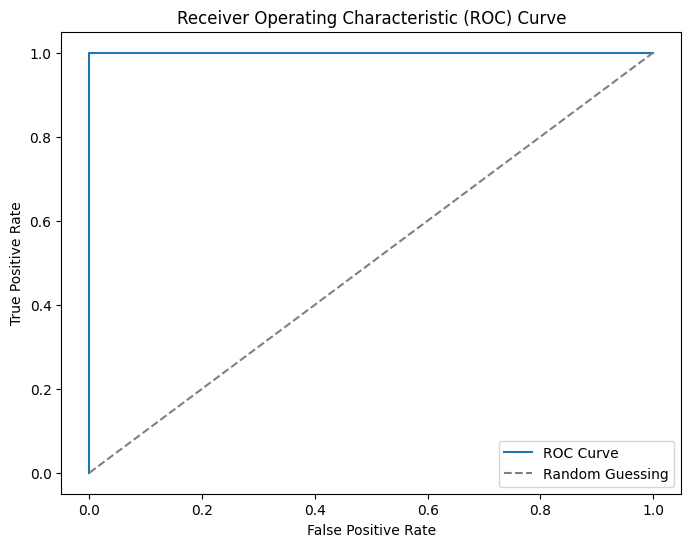

In [10]:
predicted = parent.load_and_predict(name, X_test)
observed = y_test

parent.plot_roc_curve(observed, parent.ravel(predicted))

3048/3048 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step


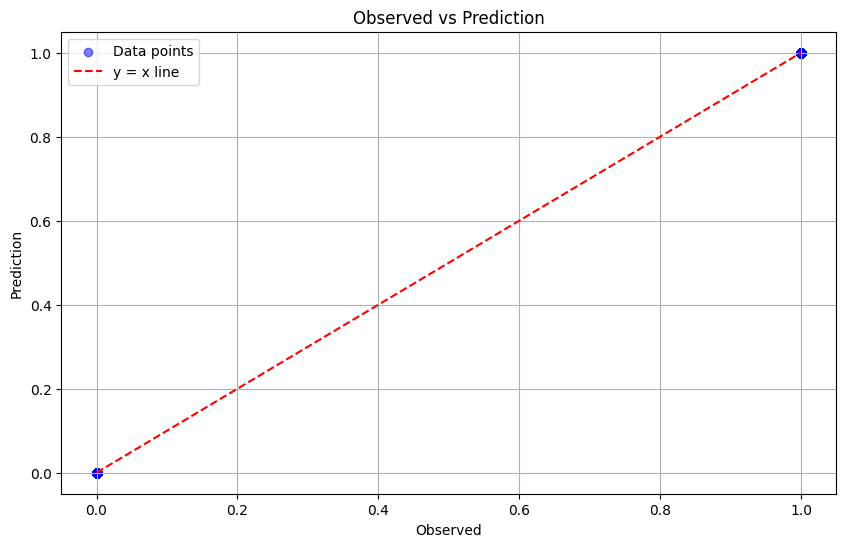

In [11]:
predicted = parent.load_and_predict(name, X)
observed = df['Reversed'].apply(lambda x: 0 if x == True else 1).values

parent.plot_scatter(observed, parent.ravel(predicted))

In [12]:
for metric, value in loss.items():
    print(f"{metric}: {value}")

accuracy: 1.0
precision: 1.0
recall: 1.0
f1_score: 1.0
auc: 1.0


#### Additional testing using the reverse_LaFleur_h10_h35.csv and Urtecho_2023_strand.csv data

234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


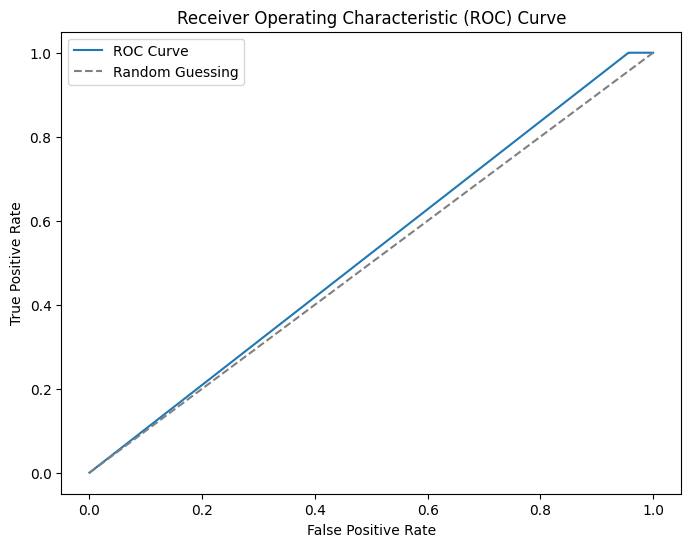

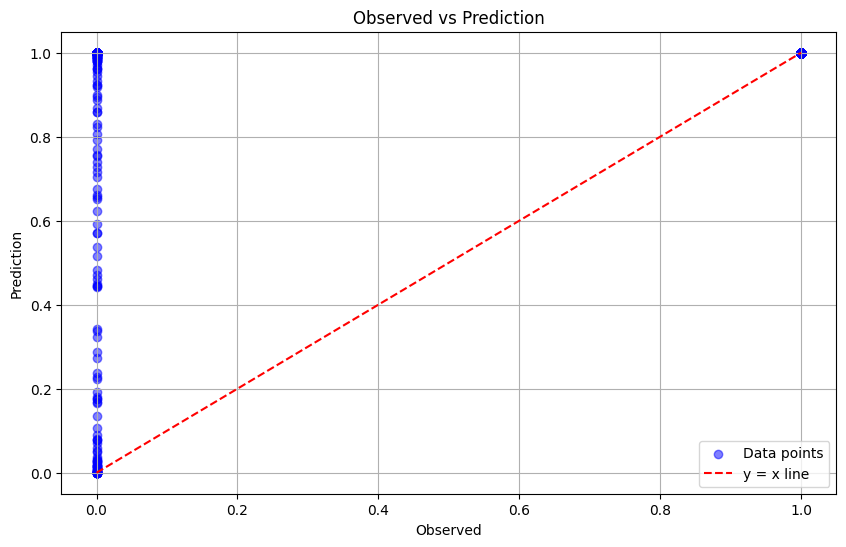

In [14]:
# load the data and sample only test_ids
df2 = parent.load_and_preprocess_data('../Data/Augmented/reverse_LaFleur_h10_h35.csv')
df2 = df2[df2['Sequence ID'].isin(test_ids)].copy()

X_test2, y_test2 = parent.combine_columns(df2)
X_test2 = parent.preprocess_sequences(X_test2)

predicted2 = parent.load_and_predict(name, X_test2)
parent.plot_roc_curve(y_test2, parent.ravel(predicted2))
parent.plot_scatter(y_test2, parent.ravel(predicted2))


1413/1413 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step


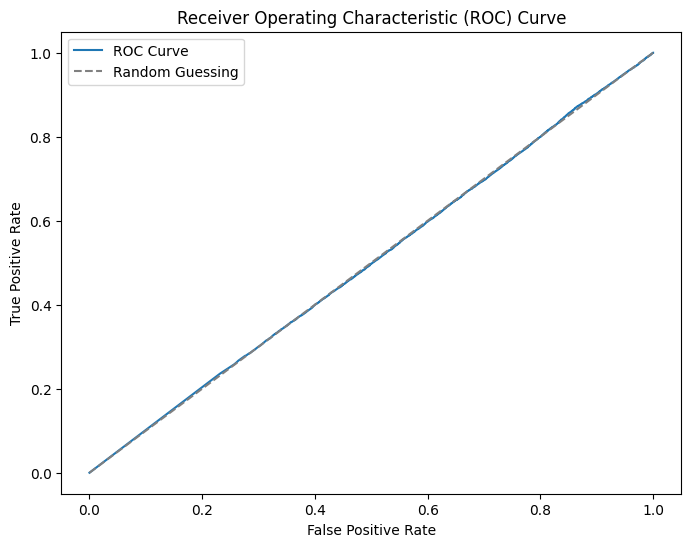

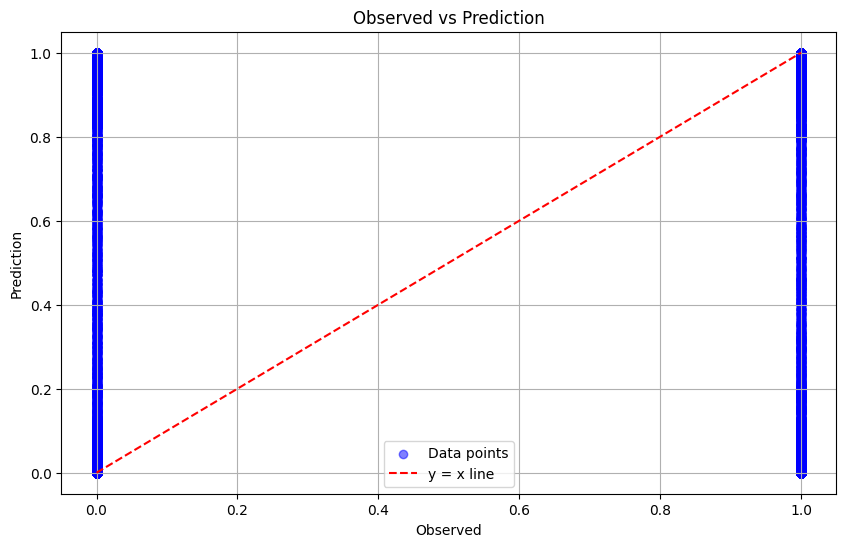

In [21]:
# load the data and sample only test_ids

import pandas as pd

df3 = pd.read_csv('../Data/Urtecho_2023/Urtecho_2023_strand.csv')
X_test3 = df3[['promoter_sequence']].astype(str).agg(''.join, axis=1)
y_test3 = df3['forward'].astype(float)
X_test3 = parent.preprocess_sequences(X_test3)

predicted3 = parent.load_and_predict(name, X_test3)
parent.plot_roc_curve(y_test3, parent.ravel(predicted3))
parent.plot_scatter(y_test3, parent.ravel(predicted3))

In [22]:
loss_Lafleur = parent.evaluate_model(model, X_test3, y_test3)
for metric, value in loss_Lafleur.items():
    print(f"{metric}: {value:.3f}")

1413/1413 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
accuracy: 0.498
precision: 0.495
recall: 0.521
f1_score: 0.507
auc: 0.500


In [ ]:
from keras.models import Sequential, load_model

model = load_model('../Models/' + name + '.keras')

In [ ]:
model.summary()